In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [15]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

In [16]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [18]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [19]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [20]:
# 實現圖片以及關機點 label 做左右翻轉的函數
def augment_data(img, points):
    rows, cols = img.shape
    new_img = np.copy(img)
    
    # 翻轉圖片
    for i in range(96):
        for j in range(48):
            temp = img[i][j]
            new_img[i][j] = img[i][cols-j-1]
            new_img[i][cols-j-1] = temp
            
    # 翻轉關鍵點 label
    new_points = np.copy(points)
    for i in range(0,30,2):
        new_points[i] = -points[i]
    
    # 調整對稱的 label
    new_points_temp = np.copy(new_points)
    new_points[0:2] = new_points_temp[2:4]
    new_points[2:4] = new_points_temp[0:2]
    new_points[4:6] = new_points_temp[8:10]
    new_points[6:8] = new_points_temp[10:12]
    new_points[8:10] = new_points_temp[4:6]
    new_points[10:12] = new_points_temp[6:8]
    new_points[12:14] = new_points_temp[16:18]
    new_points[14:16] = new_points_temp[18:20]
    new_points[16:18] = new_points_temp[12:14]
    new_points[18:20] = new_points_temp[14:16]
    new_points[22:24] = new_points_temp[24:26]
    new_points[24:26] = new_points_temp[22:24]
        
    return new_img, new_points

(4280, 96, 96)
(4280, 30)
Train on 3424 samples, validate on 856 samples
Epoch 1/150
3424/3424 [==============================] - 37s 11ms/step - loss: 0.0047 - val_loss: 0.0019

Epoch 00001: val_loss improved from inf to 0.00193, saving model to best_weights_augment.h5
Epoch 2/150
3424/3424 [==============================] - 37s 11ms/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00002: val_loss did not improve from 0.00193
Epoch 3/150
3424/3424 [==============================] - 36s 10ms/step - loss: 0.0011 - val_loss: 0.0016

Epoch 00003: val_loss improved from 0.00193 to 0.00158, saving model to best_weights_augment.h5
Epoch 4/150
3424/3424 [==============================] - 36s 11ms/step - loss: 8.0716e-04 - val_loss: 0.0014

Epoch 00004: val_loss improved from 0.00158 to 0.00140, saving model to best_weights_augment.h5
Epoch 5/150
3424/3424 [==============================] - 36s 10ms/step - loss: 6.5087e-04 - val_loss: 0.0012

Epoch 00005: val_loss improved from 0.00140 to 0.00118

3424/3424 [==============================] - 37s 11ms/step - loss: 1.5170e-04 - val_loss: 6.2912e-04

Epoch 00045: val_loss did not improve from 0.00061
Epoch 46/150
3424/3424 [==============================] - 39s 12ms/step - loss: 1.4355e-04 - val_loss: 6.3875e-04

Epoch 00046: val_loss did not improve from 0.00061
Epoch 47/150
3424/3424 [==============================] - 41s 12ms/step - loss: 1.4653e-04 - val_loss: 6.7041e-04

Epoch 00047: val_loss did not improve from 0.00061
Epoch 48/150
3424/3424 [==============================] - 36s 11ms/step - loss: 1.3986e-04 - val_loss: 6.8180e-04

Epoch 00048: val_loss did not improve from 0.00061
Epoch 49/150
3424/3424 [==============================] - 36s 10ms/step - loss: 1.3943e-04 - val_loss: 6.2899e-04

Epoch 00049: val_loss did not improve from 0.00061
Epoch 50/150
3424/3424 [==============================] - 36s 10ms/step - loss: 1.3509e-04 - val_loss: 6.1749e-04

Epoch 00050: val_loss did not improve from 0.00061
Epoch 51/150
3424

3424/3424 [==============================] - 36s 10ms/step - loss: 9.1726e-05 - val_loss: 6.4414e-04

Epoch 00094: val_loss did not improve from 0.00060
Epoch 95/150
3424/3424 [==============================] - 36s 10ms/step - loss: 9.1562e-05 - val_loss: 6.5611e-04

Epoch 00095: val_loss did not improve from 0.00060
Epoch 96/150
3424/3424 [==============================] - 35s 10ms/step - loss: 9.1804e-05 - val_loss: 6.3457e-04

Epoch 00096: val_loss did not improve from 0.00060
Epoch 97/150
3424/3424 [==============================] - 35s 10ms/step - loss: 9.2349e-05 - val_loss: 6.6440e-04

Epoch 00097: val_loss did not improve from 0.00060
Epoch 98/150
3424/3424 [==============================] - 35s 10ms/step - loss: 9.2502e-05 - val_loss: 6.3158e-04

Epoch 00098: val_loss did not improve from 0.00060
Epoch 99/150
3424/3424 [==============================] - 35s 10ms/step - loss: 9.1584e-05 - val_loss: 6.2641e-04

Epoch 00099: val_loss did not improve from 0.00060
Epoch 100/150
342

3424/3424 [==============================] - 34s 10ms/step - loss: 7.7775e-05 - val_loss: 6.6050e-04

Epoch 00143: val_loss did not improve from 0.00060
Epoch 144/150
3424/3424 [==============================] - 35s 10ms/step - loss: 7.5782e-05 - val_loss: 6.4294e-04

Epoch 00144: val_loss did not improve from 0.00060
Epoch 145/150
3424/3424 [==============================] - 35s 10ms/step - loss: 7.5120e-05 - val_loss: 6.2137e-04

Epoch 00145: val_loss did not improve from 0.00060
Epoch 146/150
3424/3424 [==============================] - 35s 10ms/step - loss: 7.5538e-05 - val_loss: 6.3902e-04

Epoch 00146: val_loss did not improve from 0.00060
Epoch 147/150
3424/3424 [==============================] - 35s 10ms/step - loss: 7.5125e-05 - val_loss: 6.3650e-04

Epoch 00147: val_loss did not improve from 0.00060
Epoch 148/150
3424/3424 [==============================] - 35s 10ms/step - loss: 7.7308e-05 - val_loss: 6.5360e-04

Epoch 00148: val_loss did not improve from 0.00060
Epoch 149/15

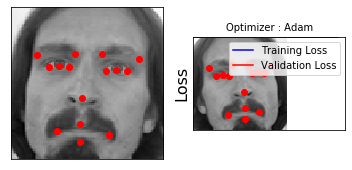

In [21]:
flip_img, flip_points = augment_data(imgs_train[0], points_train[0])

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_keypoints(imgs_train[0], points_train[0]) # 原來的圖片
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_keypoints(flip_img, flip_points) # 翻轉後的圖片


# 創建 list
aug_imgs_train = []
aug_points_train = []

# 對所有原始資料做 augmentation
for i in range(imgs_train.shape[0]):
    # 做左右翻轉
    aug_img, aug_point = augment_data(imgs_train[i], points_train[i])
    
    # append 原始資料
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i]) 
    
    # append 做過 augmentation 後的資料
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_point) 

# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)


# model checkpoint 
checkpoint_aug = ModelCheckpoint('best_weights_augment.h5', verbose=1, save_best_only=True)
# training the model
hist_model_aug = model_with_augment.fit(aug_imgs_train.reshape(aug_imgs_train.shape[0], 96, 96, 1), aug_points_train, 
                           validation_split=0.2, batch_size=64, callbacks=[checkpoint_aug, hist],
                           shuffle=True, epochs=150, verbose=1)


# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model_aug.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model_aug.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')